<a href="https://colab.research.google.com/github/BeletAntoine/Machine_Learning/blob/main/Projet1/Projet1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## <center>  Chest X-rays Detection

In [1]:
import sklearn
import tensorflow as tf
import numpy as np
import pandas as pd
import pickle
import keras
import glob
import os

In [2]:
os.environ["KERAS_BACKEND"] = "tensorflow"

### 1) Download kaggle files

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2


We get the folder structure with the code:
```
tree -L 3 path
```

Which gives the following structure:
```
Path
└── chest_xray
    ├── chest_xray
    │   ├── test
    │   ├── train
    │   └── val
    ├── __MACOSX
    │   └── chest_xray
    ├── test
    │   ├── NORMAL
    │   └── PNEUMONIA
    ├── train
    │   ├── NORMAL
    │   └── PNEUMONIA
    └── val
        ├── NORMAL
        └── PNEUMONIA
```
Files in the NORMAL and PNEUMONIA folders are all of ".jpg" extension.

### 2) Verify the data

Using the kaggle datasets, you can usually assume the dataset will be of quality, however it's still important to know your data and verify what it looks like.

Let's check that !

In [4]:
# Get the paths for the train, test and val folders
chest_xray_path = path + "/chest_xray"
test_path = chest_xray_path + "/test"
train_path = chest_xray_path + "/train"
val_path = chest_xray_path + "/val"

In [5]:
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib

# Get the Normal and Pneumonia path from a  parent folder
def normal_n_pneumonia_paths(parent_folder_path):
    return (parent_folder_path + "/NORMAL"), ( parent_folder_path + "/PNEUMONIA")

# Return random images paths from the folder given
def select_random_images_from_folder(path_folder, number_images):

    list_images_path = glob.glob(path_folder + "/**/*.jpeg", recursive=True)

    print(f'Number of images in folder : {len(list_images_path)}')

    array_numbers_len_list = np.arange(0, len(list_images_path))

    # Select number_images numbers from the list
    list_random_numbers = np.random.choice(array_numbers_len_list, number_images)

    print(f'Indices selected : {list_random_numbers}')

    return [list_images_path[i] for i in list_random_numbers]

# Print images from their path
def print_images_from_path(array_dim1_images_path):
    num_images = len(array_dim1_images_path)

    fig, axes = plt.subplots(1, num_images, figsize=(num_images * 5, 5))  # One row, multiple columns

    if num_images == 1:  # Handle single image case
        axes = [axes]

    for ax, image_path in zip(axes, array_dim1_images_path):
        img = matplotlib.image.imread(image_path)  # Read image correctly
        ax.imshow(img, cmap="gray")
        ax.axis("off")  # Hide axes

    plt.show()

# Select random images from the folder and display them
def select_n_display_images_from_folder(path_folder, number_images):
    list_random_images_paths = select_random_images_from_folder(path_folder, number_images)
    print_images_from_path(list_random_images_paths)
    return list_random_images_paths


/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/train/NORMAL
Number of images in folder : 1341
Indices selected : [777 185 935 745  52]


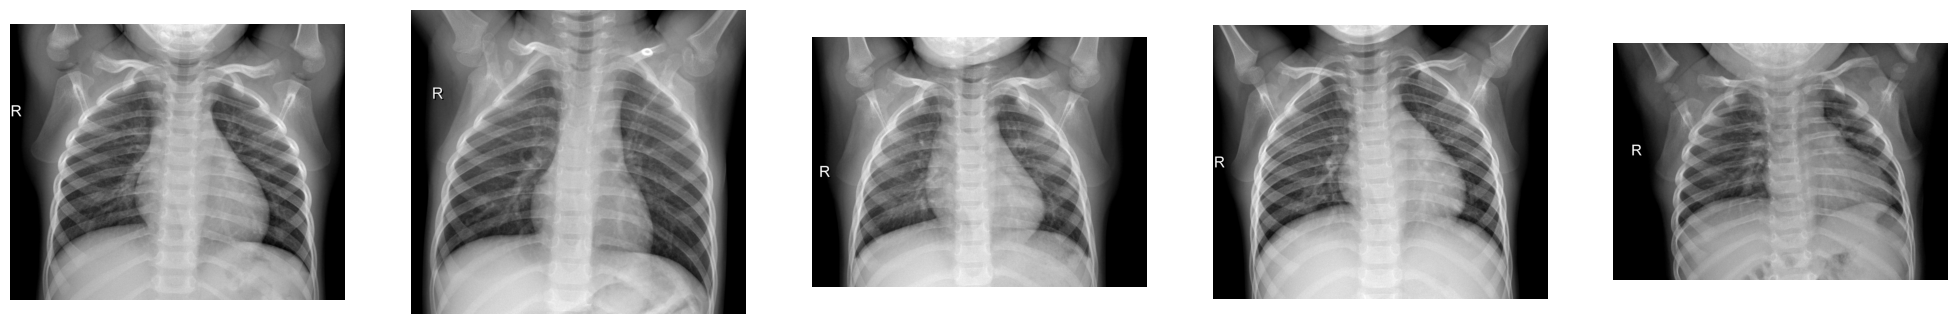

['/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/train/NORMAL/IM-0571-0001.jpeg', '/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/train/NORMAL/NORMAL2-IM-0937-0001.jpeg', '/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/train/NORMAL/NORMAL2-IM-0955-0001.jpeg', '/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/train/NORMAL/NORMAL2-IM-1096-0001-0003.jpeg', '/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/train/NORMAL/NORMAL2-IM-0458-0001.jpeg']
Number of images in folder : 3875
Indices selected : [ 218 2454  919  165  727]


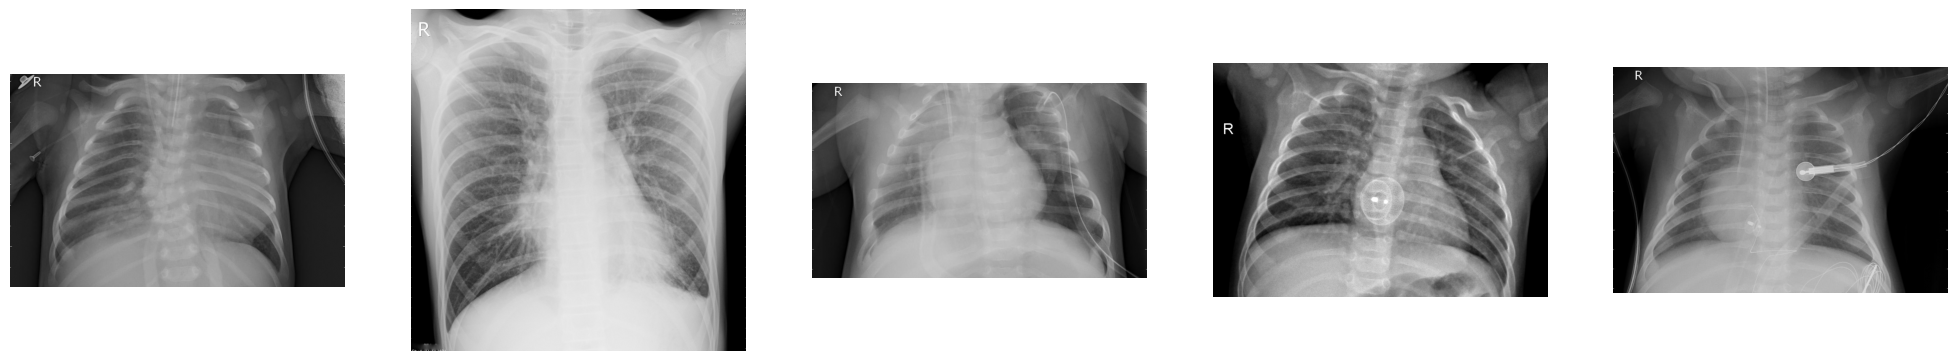

['/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/train/PNEUMONIA/person38_bacteria_190.jpeg', '/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/train/PNEUMONIA/person1544_bacteria_4035.jpeg', '/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/train/PNEUMONIA/person543_bacteria_2280.jpeg', '/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/train/PNEUMONIA/person422_bacteria_1853.jpeg', '/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/train/PNEUMONIA/person381_bacteria_1731.jpeg']


In [6]:
num_images_to_display = 5

train_normal_path, train_pneumonia_path = normal_n_pneumonia_paths(train_path)
print(train_normal_path)

list_random_images_paths_normal = select_n_display_images_from_folder(train_normal_path, num_images_to_display)
print(list_random_images_paths_normal)

list_random_images_paths_pneumonia = select_n_display_images_from_folder(train_pneumonia_path, num_images_to_display)
print(list_random_images_paths_pneumonia)


### 3) Standardise the data

The data needs to have the same shape, rescaling pixel value to [0,1]

#### Reshape

In [35]:
from PIL import Image
from collections import defaultdict

# Verify the shapes existing

def count_num_images_shapes(folder_path):
    # Dictionary to count occurrences of each unique shape
    shape_counts = defaultdict(int)

    # Loop through all files in the folder
    for filename in os.listdir(folder_path):
        if filename.lower().endswith((".jpg", ".jpeg")):
            file_path = os.path.join(folder_path, filename)
            with Image.open(file_path) as img:
                shape = img.size  # (width, height)
                shape_counts[shape] += 1  # Count occurrences of each shape

    # Print unique shapes and their counts
    #for shape, count in shape_counts.items():
    #    print(f"Shape {shape}: {count} images")
    nb_shapes = 10
    if len(shape_counts.items()) > nb_shapes:
      print(f"There are more than {nb_shapes} different shapes in this dictionary.")

    return shape_counts

In [36]:
dictionary_shapes = count_num_images_shapes(train_normal_path)

There are more than 10 different shapes in this dictionary.


All the shapes are different, let's try ro find a shape that would work on all images, starting with the minimum shape (both width and height).

In [37]:
list_shapes = list(dictionary_shapes.keys())

# Get the min width and heigth
min_width, min_height = list(map(min, zip(*list_shapes)))
print(f"Min width: {min_width} \nMin height: {min_height}")

Min width: 912 
Min height: 672


We like powers of 2 for shapes as it works very well with maximisation of physical space, pooling steps, etc.

Let's reshape our images to (224, 224) wich is the value most pre-trained models have been trained on. Also the lower values for the width and height are to avoid using padding on images.

All images seem to have been resized without any issues, let's start loading the whole dataset for training.

In [38]:
import os

def count_files_and_classes(folder_path):

    # Get the list of subfolders (classes)
    class_names = sorted(os.listdir(folder_path))
    num_classes = len(class_names)

    # Count the number of files in each class
    class_counts = {}
    total_files = 0

    for class_name in class_names:
        class_folder = os.path.join(folder_path, class_name)
        if os.path.isdir(class_folder):  # Ensure it's a directory
            num_files = len(os.listdir(class_folder))
            class_counts[class_name] = num_files
            total_files += num_files

    return class_counts, total_files, num_classes

In [39]:
# Check the training dataset
class_counts, total_files, num_classes = count_files_and_classes(train_path)

# Print the results
print("Training class counts:", class_counts)
print("Training total number of files:", total_files)
print("Training total number of classes:", num_classes)

Training class counts: {'NORMAL': 1341, 'PNEUMONIA': 3875}
Training total number of files: 5216
Training total number of classes: 2


In [40]:
# Check the Validation dataset
class_counts, total_files, num_classes = count_files_and_classes(val_path)

# Print the results
print("Validation class counts:", class_counts)
print("Validation total number of files:", total_files)
print("Validation total number of classes:", num_classes)

Validation class counts: {'NORMAL': 8, 'PNEUMONIA': 8}
Validation total number of files: 16
Validation total number of classes: 2


In [41]:
# Check the Validation dataset
class_counts, total_files, num_classes = count_files_and_classes(test_path)

# Print the results
print("Test class counts:", class_counts)
print("Test total number of files:", total_files)
print("Test total number of classes:", num_classes)

Test class counts: {'NORMAL': 234, 'PNEUMONIA': 390}
Test total number of files: 624
Test total number of classes: 2


Sometimes even having a great database is not enough. I will use data augmentation to diversify the datasets.

In [42]:
def directory_path_to_keras_dataset(directory_path, target_size):


    # create the dataset with keras directly from the directory
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
                  directory_path,
                  image_size=target_size,
                  label_mode="binary",
                  color_mode="rgb",
                  batch_size=batch_size,
                  shuffle=True,
                  seed=42,
                  )

    # Prefetch for performance
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    print(f"Number of batches = {dataset.cardinality().numpy()}")

    return dataset

Load the datasets

In [43]:
# Define image size
width = 224
height = 224
target_size = (width, height)  # Desired shape
batch_size = 128

In [44]:
import tensorflow as tf

# Create training dataset
train_dataset = directory_path_to_keras_dataset(train_path, target_size)

# Create validation dataset
val_dataset = directory_path_to_keras_dataset(val_path, target_size)

# Load test dataset
test_dataset = directory_path_to_keras_dataset(test_path, target_size)

Found 5216 files belonging to 2 classes.
Number of batches = 41
Found 16 files belonging to 2 classes.
Number of batches = 1
Found 624 files belonging to 2 classes.
Number of batches = 5


In [45]:
# Inspect the first batch of the training dataset
for images, labels in train_dataset.take(1):
    print("Images shape:", images.shape)  # Should be (batch_size, width, height, 1) the last number is of dimension one because of b&w image
    print("Labels shape:", labels.shape)  # Should be (batch_size,)

Images shape: (128, 224, 224, 3)
Labels shape: (128, 1)


In [46]:
# Inspect the first batch of the validation dataset
for images, labels in val_dataset.take(1):
    print("Images shape:", images.shape)  # Should be (batch_size, width, height, 1) the last number is of dimension one because of b&w image
    print("Labels shape:", labels.shape)  # Should be (batch_size,)

Images shape: (16, 224, 224, 3)
Labels shape: (16, 1)


We have to balance the classes as well

In [53]:
from sklearn.utils import class_weight as sklearn_class_weight  # Rename the imported module

def balance_weight_classes(dataset):
    # Extract labels from the dataset
    labels = np.concatenate([y.numpy() for x, y in dataset], axis=0)  # Convert to NumPy array
    labels = labels.flatten()  # Ensure labels are 1D

    # Compute class weights
    class_weight = sklearn_class_weight.compute_class_weight(
        'balanced',
        classes=np.unique(labels),
        y=labels
    )

    # Convert to a dictionary
    class_weight = dict(enumerate(class_weight))

    return class_weight

In [54]:
# Balancing the classes
train_classes_weights = balance_weight_classes(train_dataset)
print(train_classes_weights)

### 4) Creation of model

In [55]:
input_shape = (width, height, 3)  # Desired shape for rgb image
nb_classes = 1

Pre-trained model

In [56]:
import keras_hub

image_classifier = keras_hub.models.ImageClassifier.from_preset(
    "resnet_vd_200_imagenet",
    activation="sigmoid",
    input_shape=input_shape,
    num_classes=nb_classes,
)

image_classifier.summary()

Preprocessor: "res_net_image_classifier_preprocessor_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ res_net_image_converter_9 (ResNetImageConverter)              │                   Image size: (224, 224) │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "res_net_image_classifier_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                  ┃ Output Shape                       ┃             Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)                    │ (None, None, None, 3)              │                   0 │
├───────────────────────────────────────────────┼────────────────────────────────────┼─────────────────────┤
│ res_net_backbone_9 (ResNetBackbone)           │ (None, None, None, 2048)           │          72,884,064 │
├───────────────────────────────────────────────┼────────────────────────────────────┼─────────────────────┤
│ pooler (GlobalAveragePooling2D)               │ (None, 2048)                       │                   0 │
├───────────────────────────────────────────────┼────────────────────────────────────┼─────────────────────┤
│ output_dropout (Dropout)                      │ (None, 2048)                       │                   0 │
├───────────────────────────────────────────────┼────────────────────────────────────┼─────────────────────┤
│ predictions (Dense)                           │ (None, 1)                          │               2,049 │
└───────────────────────────────────────────────┴────────────────────────────────────┴─────────────────────┘

 Total params: 72,886,113 (278.04 MB)

 Trainable params: 72,691,553 (277.30 MB)

 Non-trainable params: 194,560 (760.00 KB)

### 5) Training

In [57]:
# Variables used in the training section
epochs = 100

Pre-trained Model

In [58]:
image_classifier.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5), # LR reduced to avoid
    loss='binary_crossentropy',
    metrics=[keras.metrics.BinaryAccuracy (name="acc"),
             keras.metrics.Precision(name="precision"),
             keras.metrics.Recall(name="recall"),
             keras.metrics.AUC(name="auc")]
)

best_pretrained_model_path = "best_pretrained_model.keras"

image_classifier_callbacks = [
    keras.callbacks.ModelCheckpoint(best_pretrained_model_path, save_best_only=True),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=5),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=3)
]

In [60]:
history_image_classifier = image_classifier.fit(
        train_dataset,
        epochs=epochs,
        callbacks=image_classifier_callbacks,
        validation_data=val_dataset,
        class_weight=train_classes_weights,
        verbose=1
    )

Epoch 1/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 244s 2s/step - acc: 0.7789 - auc: 0.8839 - loss: 0.4310 - precision: 0.9379 - recall: 0.7459 - val_acc: 0.8125 - val_auc: 1.0000 - val_loss: 0.3159 - val_precision: 0.7273 - val_recall: 1.0000 - learning_rate: 1.0000e-05
Epoch 2/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 23s 543ms/step - acc: 0.9820 - auc: 0.9978 - loss: 0.0587 - precision: 0.9956 - recall: 0.9799 - val_acc: 1.0000 - val_auc: 1.0000 - val_loss: 0.1294 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 1.0000e-05
Epoch 3/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 18s 416ms/step - acc: 0.9999 - auc: 1.0000 - loss: 0.0080 - precision: 1.0000 - recall: 0.9999 - val_acc: 0.8750 - val_auc: 1.0000 - val_loss: 0.2459 - val_precision: 0.8000 - val_recall: 1.0000 - learning_rate: 1.0000e-05
Epoch 4/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 17s 411ms/step - acc: 1.0000 - auc: 1.0000 - loss: 0.0029 - precision: 1.0000 - recall: 1.0000 - val_acc: 0.8125 - val_auc: 1.0000 - val_loss: 0.2968 - val_precision: 0.7273 - v

In [61]:
# Access history data
print(history_image_classifier.history.keys())  # Shows available metrics like loss, accuracy, etc.
print(history_image_classifier.history['loss'])  # Prints loss value per epoch
print(history_image_classifier.history['acc'])  # Prints accuracy value per epoch
print(history_image_classifier.history['precision'])  # Prints Precision value per epoch
print(history_image_classifier.history['recall'])  # Prints Recall value per epoch
print(history_image_classifier.history['auc'])  # Prints AUC value per epoch

dict_keys(['acc', 'auc', 'loss', 'precision', 'recall', 'val_acc', 'val_auc', 'val_loss', 'val_precision', 'val_recall', 'learning_rate'])
[0.2790549695491791, 0.04313573241233826, 0.006805287674069405, 0.002519932808354497, 0.001371152000501752, 0.0010680992854759097, 0.0012373863719403744]
[0.8746165633201599, 0.9875383377075195, 0.9998083114624023, 1.0, 1.0, 1.0, 1.0]
[0.978318989276886, 0.9971294403076172, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.8500645160675049, 0.9860644936561584, 0.9997419118881226, 1.0, 1.0, 1.0, 1.0]
[0.9656317234039307, 0.9987718462944031, 0.9999998807907104, 1.0, 1.0, 1.0, 1.0]


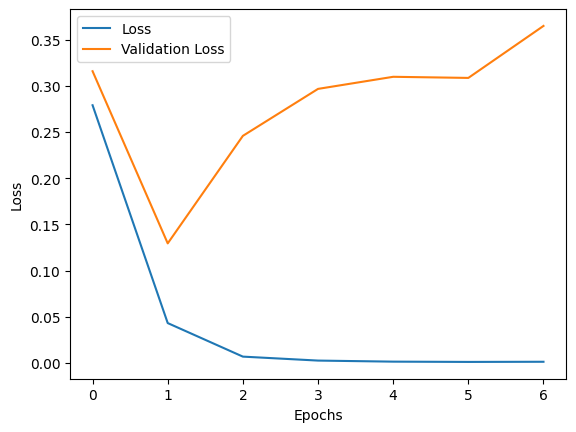

In [62]:
# Plot training loss
import matplotlib.pyplot as plt
plt.plot(history_image_classifier.history['loss'], label='Loss')
plt.plot(history_image_classifier.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 6) Evaluation

Pre_trained model

In [63]:
score_pretrained_model = image_classifier.evaluate(test_dataset)

5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - acc: 0.8337 - auc: 0.9335 - loss: 0.6230 - precision: 0.7942 - recall: 0.9918


In [64]:
# Print the evaluation results
print(f"Test Loss: {score_pretrained_model[0]}")
print(f"Test Accuracy: {score_pretrained_model[1]}")
print(f"Test Precision: {score_pretrained_model[2]}")
print(f"Test Recall: {score_pretrained_model[2]}")

f1_score_pretrained_model = 2 * (score_pretrained_model[2] * score_pretrained_model[3]) / (score_pretrained_model[2] + score_pretrained_model[3])
print(f"Test F1 Score: {f1_score_pretrained_model}")

Test Loss: 0.6749909520149231
Test Accuracy: 0.8237179517745972
Test Precision: 0.78340083360672
Test Recall: 0.78340083360672
Test F1 Score: 0.8755656143579508


### 7) Application

In [65]:
import cv2
from scipy.ndimage import zoom

As seen in the resnet_50 model summary we have a pooling and a prediction layer for the transfer learning, we're going to use them to display the heatmap over the image.

In [66]:
from tensorflow.keras.models import Model

# Get the output layers that we want from the model
conv_output = image_classifier.get_layer("res_net_backbone_9").output
pred_ouptut = image_classifier.get_layer("predictions").output

# Create the same model to have 2 outputs (pooling, predictions) instead of only predictions
applied_image_classifier = Model(image_classifier.input, outputs=[conv_output, pred_ouptut])

In [67]:
# Number of images to display
N = 5

In [68]:
# Select randomly pictures
random_image_path = select_random_images_from_folder(test_path, N) # Get the first and only element from the list

# Load the image and resize it from it's path
def load_and_resize_image(image_path, target_size):
    img = cv2.imread(image_path)
    img = cv2.resize(img, target_size)
    return img

list_imgs = [load_and_resize_image(path, target_size) for path in random_image_path]

# Expands the dimensions to fit it to the input shape of the model
X = tf.convert_to_tensor(list_imgs)
print(X.shape)

# Get the results of the prediction on the picture
conv, pred = applied_image_classifier.predict(X)
print(f"Prediction classes: {pred}")
print(f"Shape convolution layer output : {conv.shape}")

Number of images in folder : 624
Indices selected : [282 579 567 326  34]
(5, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step
Prediction classes: [[0.0000000e+00]
 [1.9375577e-34]
 [0.0000000e+00]
 [6.0895470e-19]
 [0.0000000e+00]]
Shape convolution layer output : (5, 7, 7, 2048)


In [69]:
def pred_to_text(pred):
    prediction = np.argmax(pred)
    if prediction == 0:
        return "NORMAL"
    else:
        return "PNEUMONIA"

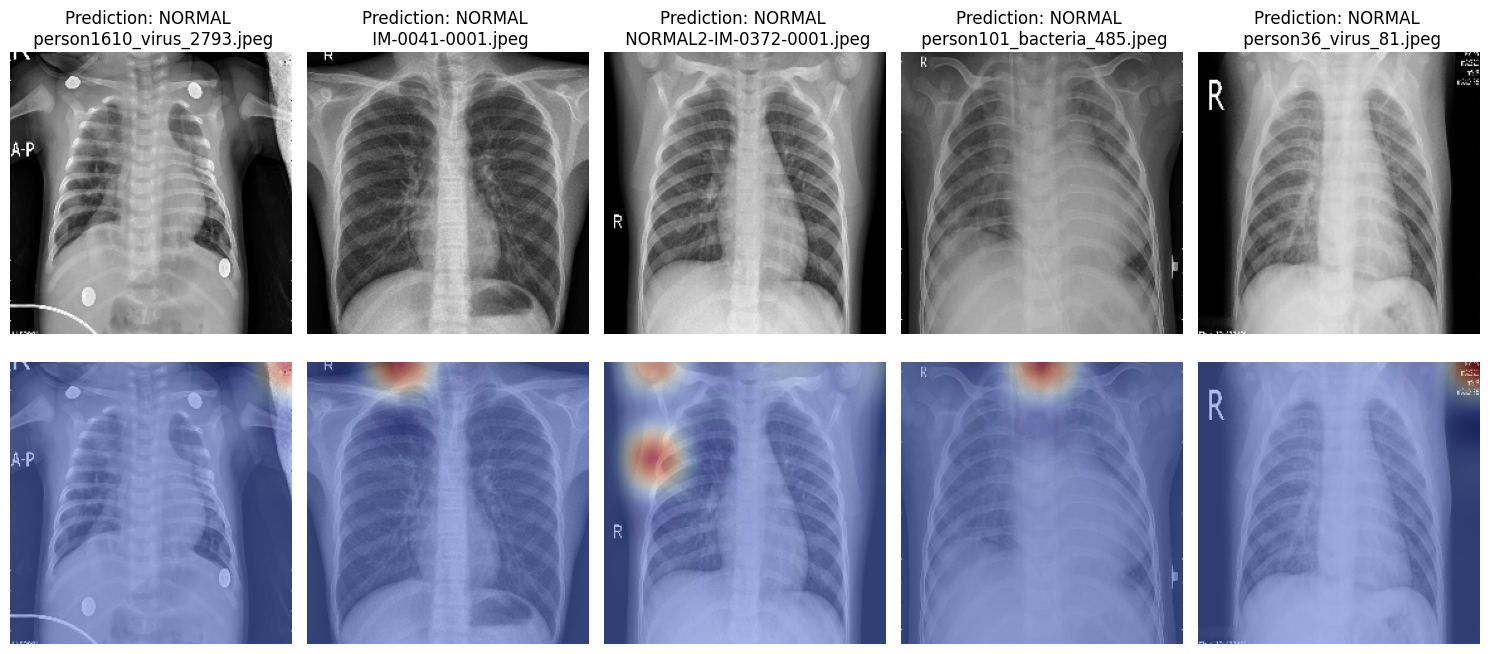

In [70]:
from scipy.ndimage import zoom
import matplotlib.pyplot as plt

# Example scaling factor (adjust based on your model's output shape) here the last conv layer shape was (5, 7, 7, 2048) as seen 2 cells above
# We know the pictures are of shape (224, 224) the last conv layer of the pre-trained model gives a (_, 7, 7, _) image
# The scaling factor should be 224/7 : (width OR height) / (conv.shape[1] OR conv.shape[2])
scale = width / conv.shape[1]

# Create a figure with N subplots
plt.figure(figsize=(3*N, 7))  # Adjust the figure size as needed

for i in range(N):
    # Display the original image
    plt.subplot(2, N, i+1)
    plt.imshow(cv2.cvtColor(list_imgs[i], cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for display
    plt.axis('off')
    plt.title(f"Prediction: {pred_to_text(pred[i][0])} \n {os.path.basename(random_image_path[i])}")

    # Generate the heatmap
    heatmap = np.mean(conv[i], axis=-1)  # Average over the channels to get a 2D heatmap
    heatmap = np.maximum(heatmap, 0)  # ReLU activation
    heatmap = (heatmap - np.min(heatmap)) / (np.max(heatmap) - np.min(heatmap))  # Normalize between 0, 1

    # Apply the tangent function to exacerbate the interesting parts of the heatmap
    treshold_heatmap = 0.8 # Threshold between 0 and 1 to intensify the values above
    multiplication_factor = 5
    heatmap = np.tanh((heatmap - treshold_heatmap) * multiplication_factor) # Scale the heatmap values

    # Normalize again after the tanh application
    heatmap /= np.max(np.abs(heatmap))
    # Redo the ReLu activation
    heatmap = np.maximum(heatmap, 0)  # ReLU activation

    # Resize the heatmap to match the original image size
    scale = list_imgs[i].shape[0] / heatmap.shape[0]
    heatmap = zoom(heatmap, zoom=(scale, scale))

    # Display the heatmap over the original image
    plt.subplot(2, N, N + i + 1)
    plt.imshow(cv2.cvtColor(list_imgs[i], cv2.COLOR_BGR2RGB))
    plt.imshow(heatmap, cmap='coolwarm', alpha=0.5)  # Overlay the heatmap with transparency
    plt.axis('off')

plt.tight_layout()  # Adjust spacing between subplots
plt.show()